This notebook should be processed after the initial pre-processing and emotion weight data


In [1]:
# TODO:
# 多线程优化

# 找到一些其他的数据集，然后实践，看泛化性
# 情感方向（广一些）

# 看 percentage, 改阈值
# CLIP为 plan b (too much...)

# 看单个case的近义词，不删除，但是cluster
# | <- 分隔符

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sys
import os

# use only for dictionary parsing...
import ast

# 0. Review: synonyms detection
## synonymNet
https://arxiv.org/abs/1901.00056https://arxiv.org/abs/1901.00056

Being able to automatically discover synonymous entities in an open-world setting benefits various tasks such as entity disambiguation or knowledge graph canonicalization. Existing works either only utilize entity features, or rely on structured annotations from a single piece of context where the entity is mentioned. To leverage diverse contexts where entities are mentioned, in this paper, we generalize the distributional hypothesis to a multi-context setting and propose a synonym discovery framework that detects entity synonyms from free-text corpora with considerations on effectiveness and robustness. As one of the key components in synonym discovery, we introduce a neural network model SYNONYMNET to determine whether or not two given entities are synonym with each other. Instead of using entities features, SYNONYMNET makes use of multiple pieces of contexts in which the entity is mentioned, and compares the context-level similarity via a bilateral matching schema. Experimental results demonstrate that the proposed model is able to detect synonym sets that are not observed during training on both generic and domain-specific datasets: Wiki+Freebase, PubMed+UMLS, and MedBook+MKG, with up to 4.16% improvement in terms of Area Under the Curve and 3.19% in terms of Mean Average Precision compared to the best baseline method.Being able to automatically discover synonymous entities in an open-world setting benefits various tasks such as entity disambiguation or knowledge graph canonicalization. Existing works either only utilize entity features, or rely on structured annotations from a single piece of context where the entity is mentioned. To leverage diverse contexts where entities are mentioned, in this paper, we generalize the distributional hypothesis to a multi-context setting and propose a synonym discovery framework that detects entity synonyms from free-text corpora with considerations on effectiveness and robustness. As one of the key components in synonym discovery, we introduce a neural network model SYNONYMNET to determine whether or not two given entities are synonym with each other. Instead of using entities features, SYNONYMNET makes use of multiple pieces of contexts in which the entity is mentioned, and compares the context-level similarity via a bilateral matching schema. Experimental results demonstrate that the proposed model is able to detect synonym sets that are not observed during training on both generic and domain-specific datasets: Wiki+Freebase, PubMed+UMLS, and MedBook+MKG, with up to 4.16% improvement in terms of Area Under the Curve and 3.19% in terms of Mean Average Precision compared to the best baseline method.

In [3]:
import synonyms

smart_open library not found; falling back to local-filesystem-only


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


[jieba] default dict file path ..\data\vocab.txt
[jieba] default dict file path ..\data\vocab.txt
[jieba] load default dict ..\data\vocab.txt ...
[jieba] load default dict ..\data\vocab.txt ...
>> Synonyms load wordseg dict [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\vocab.txt] ... 
>> Synonyms on loading stopwords [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\stopwords.txt] ...
[Synonyms] on loading vectors [C:\Python\miniconda3\envs\story_cloze\lib\site-packages\synonyms\data\words.vector.gz] ...


In [4]:
# 中文还行
print("开心: ", synonyms.nearby("开心"))
print("伤心: ", synonyms.nearby("伤心"))
print("NOT_EXIST: ", synonyms.nearby("NOT_EXIST"))

开心:  (['开心', '高兴', '兴奋', '愉快', '难过', '快乐', '伤心', '痛快', '尽兴', '得意'], [1.0, 0.80510014, 0.7370683, 0.7110831, 0.7060874, 0.69482696, 0.67555505, 0.65788877, 0.6525332, 0.64982194])
伤心:  (['伤心', '难过', '心痛', '悲伤', '悲痛', '悔恨', '心疼', '郁闷', '悲愤', '忐忑'], [1.0, 0.87252134, 0.8377604, 0.82897615, 0.7907454, 0.75183433, 0.7486311, 0.7461942, 0.7386005, 0.7325378])
NOT_EXIST:  ([], [])


In [5]:
# 英文寄了
print("happy: ", synonyms.nearby("happy"))
print("sad: ", synonyms.nearby("sad"))

happy:  (['happy', 'Let', 'is', 'This', 'all', 'it', 'To', 'fame', 'spend', 'creates'], [1.0, 0.6119284, 0.5868017, 0.5624877, 0.5546613, 0.5529554, 0.5517211, 0.5055882, 0.49800324, 0.46012384])
sad:  (['sad', 'failing', 'esta', 'initially', 'Though', 'defend', 'returning', 'fame', 'begun', 'proved'], [1.0, 0.5269767, 0.52678764, 0.5045616, 0.49744284, 0.49625623, 0.4941613, 0.4784833, 0.4747744, 0.4695003])


## NLTK - wordnet

In [4]:
from nltk.corpus import wordnet

# TODO: 试试 concept net
# 近义词查找： 比较难
# embedding: not universal: ambiguity
# hard to generalize
# 

In [7]:
wordnet.synsets('happy')

[Synset('happy.a.01'),
 Synset('felicitous.s.02'),
 Synset('glad.s.02'),
 Synset('happy.s.04')]

In [8]:
def wordNetCheck(wordInput):
    # Then, we're going to use the term "program" to find synsets like so:
    syns = wordnet.synsets(wordInput)

    # An example of a synset:
    print(syns[0].name())

    # Just the word:
    print(syns[0].lemmas()[0].name())

    # Definition of that first synset:
    print(syns[0].definition())

    # Examples of the word in use in sentences:
    print(syns[0].examples(), "\n")

In [9]:
wordNetCheck('happy')

wordNetCheck('glad')

happy.a.01
happy
enjoying or showing or marked by joy or pleasure
['a happy smile', 'spent many happy days on the beach', 'a happy marriage'] 

gladiolus.n.01
gladiolus
any of numerous plants of the genus Gladiolus native chiefly to tropical and South Africa having sword-shaped leaves and one-sided spikes of brightly colored funnel-shaped flowers; widely cultivated
[] 



We can use this framework to find possible synonyms & antonyms

In [10]:
import nltk
from nltk.corpus import wordnet
synonyms = []
antonyms = []
for syn in wordnet.synsets("distressed"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())
            
print(set(synonyms))
print(set(antonyms))

list(x.antonyms()[0].name() for y in wordnet.synsets("distressed") for x in y.lemmas() if x.antonyms())
list(set(list(emotion.name() for allrelated in wordnet.synsets("distressed") for emotion in allrelated.lemmas())))

{'straiten', 'unhappy', 'dysphoric', 'disquieted', 'disturbed', 'worried', 'hard_put', 'upset', 'stressed', 'hard-pressed', 'distressed', 'in_a_bad_way', 'distress'}
{'euphoric'}


['straiten',
 'unhappy',
 'dysphoric',
 'disquieted',
 'disturbed',
 'worried',
 'hard_put',
 'upset',
 'stressed',
 'hard-pressed',
 'distressed',
 'in_a_bad_way',
 'distress']

Method 1：

Create undirected weighted graph and find link or path


👇

Method 2：

use wordNet definition of each emotion to find context similarities


## 0.1 Using wordnet to calculate weight

In [5]:
def calculateRelavancyUsingWordNet(e1, e2, threshold):
    """
    This function using BFS to calculate the potential weight of 2 emotion
    
    @param e1:        represents a emotion
    @param e2:        represents a emotion
    @param threshold: store the maximum score allowed for 2 emotion(usually <= 3)
    e.g. 1. we expected score == 0 when e1 == e2
    
         2. we expected 0 <= score <= threshold when e1 -> e2 is highly related
            else score = MAX_INT
    """
    
    # invalid input
    if (e1.count(" ") > 0 or e2.count(" ") > 0):
        print("Warning: \""+ e1 + "\" or \"" + e2 + "\" is not a word")
    if (threshold <= 0):
        raise Exception("Error: invalid threshold")
    
    # case: same, no need to analyze
    if (e1 == e2): return 0;

    # case: normal, start limited BFS
    visited = [e1]
    queue = [e1]
    level = [[] for i in range(threshold)]
    level[0].append(e1)
    while queue:
        currentEmotion = queue.pop(0)
        if ([currentEmotion in x for x in level].index(True) + 1 >= threshold): break;
        for neighbour in np.unique(list(set(list(emotion.name() for allrelated in wordnet.synsets(currentEmotion) for emotion in allrelated.lemmas())))):
            if (neighbour == e2):
                # print("Success: BFS level-of-nodes report for \"{}\": {}\n".format(e1, level))
                return len([nested for nested in level if nested]) - 1
            if neighbour not in visited:
                level[[currentEmotion in x for x in level].index(True) + 1].append(neighbour) # get parent's level to set neighbour to a proper pos
                visited.append(neighbour)
                queue.append(neighbour)
            
    return sys.maxsize

In [6]:
print("expected: {}, get: {}".format(1, calculateRelavancyUsingWordNet("happy", "glad", 3)))
print("expected: {}, get: {}".format("sys max int", calculateRelavancyUsingWordNet("unhappy", "happy", 3)))
print("expected: {}, get: {}".format(0, calculateRelavancyUsingWordNet("sad", "sad", 3)))

expected: 1, get: 1
expected: sys max int, get: 9223372036854775807
expected: 0, get: 0


# Start analyzing 

In [25]:
# set what we analyze
currentAnalyze = pd.read_csv('dev/emotion/allcharlinepairs-withDataCleaning-v2.csv')
# currentAnalyze = pd.read_csv('test/emotion/allcharlinepairs-withDataCleaning-v2.csv')

In [26]:
currentAnalyze['emotion'] = [ast.literal_eval(x) for x in currentAnalyze['emotion']]
currentAnalyze['plutchik'] = [ast.literal_eval(x) for x in currentAnalyze['plutchik']]

In [27]:
# 看一下内容状态
# count related
# 每个emotion x 在总字典X[x]中先记录一次freq，
# 然后同case下的其它情感yi \in {[y1, ..., yn], s.t. yi != x}记录一下freq到Y[x][yi]
emotionSum = {}
for dataRow in currentAnalyze['emotion']:
    print("\r", end="")
    print("Emoton counting and analyzing -> Start checking, current dict size: {} ".format(len(emotionSum)), end="")
    # for emotion in dataRow.values(): # use for show freq distribution
    for emotion in dataRow.keys():
        if emotion in emotionSum:
            relatedEmotionDict = emotionSum.get(emotion)[1];
            for relatedEmotion in dataRow:
                if relatedEmotion != emotion:
                    relatedEmotionDict[relatedEmotion] = relatedEmotionDict.get(relatedEmotion, 0) + 1
            emotionSum[emotion] = [emotionSum.get(emotion)[0]+1, relatedEmotionDict];
        else:
            emotionSum[emotion] = [1, {}];

Emoton counting and analyzing -> Start checking, current dict size: 1923 

In [28]:
emotionDF = pd.DataFrame(list(zip(emotionSum.keys(),[x[0] for x in emotionSum.values()], 
                        [list(z[0] for z in sorted(y[1].items(), key=lambda x: x[1], reverse=True))[0:5] for y in emotionSum.values()],
                        [sorted(y[1].items(), key=lambda x: x[1], reverse=True) for y in emotionSum.values()])), 
                         columns = ['emotion','freq','highly related', 'all related info']).sort_values(by=['freq'], na_position='first', ascending=False)

emotionDF = emotionDF.reset_index(drop=True)

In [29]:
print(emotionDF.shape)
emotionDF

(1923, 4)


,emotion,freq,highly related,all related info
0,happy,3216,"[excited, proud, relieved, satisfied, surprised]","[(excited, 934), (proud, 410), (relieved, 300)..."
1,excited,1855,"[happy, proud, nervous, surprised, anticipation]","[(happy, 934), (proud, 197), (nervous, 150), (..."
2,sad,1396,"[disappointed, angry, upset, happy, frustrated]","[(disappointed, 280), (angry, 220), (upset, 21..."
3,proud,944,"[happy, excited, accomplished, satisfied, surp...","[(happy, 410), (excited, 197), (accomplished, ..."
4,angry,821,"[sad, upset, annoyed, frustrated, disappointed]","[(sad, 220), (upset, 185), (annoyed, 162), (fr..."
...,...,...,...,...
1918,questioned,1,[],[]
1919,courteous,1,[],[]
1920,eating,1,[],[]
1921,self-conscience,1,[],[]


In [34]:
emotionDF = emotionDF[emotionDF['freq'] > 1]
emotionDF = emotionDF.reset_index(drop=True)

In [13]:
emotionDF.to_csv('./emotionRelevance-dev-highFreq.csv')
# emotionDF.to_csv('./emotionRelevance-test-highFreq.csv')

# Graph weight calculation

In [35]:
emotionRelevanceWeight = pd.DataFrame(columns = ['node0', 'node1', 'weight'])
emotionFreq = {}

In [36]:
from IPython.display import clear_output

def findGraphWeight(indexRange):
    # print("start: ", indexRange)
    global emotionRelevanceWeight
    for indexFrom in indexRange:
        emotionFreq[emotionDF['emotion'][indexFrom]] = emotionDF['freq'][indexFrom]
        for indexTo in range(indexFrom+1, emotionDF.index.stop):
            # clear_output(wait=True)
            print("\r", end="")
            print("Graph weight calculation -> Start analyzing, current process: {}/{}. Total process: {}/{}...".format(indexTo, emotionDF.index.stop - 1, 
                                                                                                                     indexFrom, indexRange.stop - 1), end="")
            weight = min(calculateRelavancyUsingWordNet(emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], 3), 
                         calculateRelavancyUsingWordNet(emotionDF['emotion'][indexTo], emotionDF['emotion'][indexFrom], 3))
            
            if (weight < sys.maxsize):
                emotionRelevanceWeight = pd.concat([emotionRelevanceWeight, pd.DataFrame([[emotionDF['emotion'][indexFrom], emotionDF['emotion'][indexTo], weight]], 
                                                                           columns = ['node0', 'node1', 'weight'])], ignore_index=True)

In [37]:
findGraphWeight(range(emotionDF.index.stop))
# import _thread
# multithreadIndex = 50
# try:
#     for i in range(0, emotionDF.index.stop-emotionDF.index.stop//multithreadIndex, emotionDF.index.stop//multithreadIndex):
#         _thread.start_new_thread( findGraphWeight, (range(i, i+100), ))
#         print("start: ", range(i, i+100), emotionDF.index.stop)
#     _thread.start_new_thread( findGraphWeight, (range(emotionDF.index.stop-emotionDF.index.stop//multithreadIndex, emotionDF.index.stop+1), ))
#     print("start: ", range(emotionDF.index.stop-emotionDF.index.stop//10, emotionDF.index.stop+1), emotionDF.index.stop)
# except Exception as e: print("FAIL!")

Graph weight calculation -> Start analyzing, current process: 1148/1148. Total process: 1147/1148...

In [38]:
emotionRelevanceWeight
# emotion 放 input 有问题
# 如果用于输入：不用replace: LM pretrain能理解
# 如果用于 replace: 可以合并label
# 

,node0,node1,weight
0,happy,glad,1
1,happy,happier,1
2,excited,mad,1
3,excited,sick,2
4,excited,disturbed,2
...,...,...,...
2693,open,able,2
2694,orderly,neat,1
2695,stern,relentless,1
2696,attacked,outrage,2


In [39]:
emotionRelevanceWeight.to_csv('./emotionRelevanceWeight-dev-threadhold3.csv')
# emotionRelevanceWeight.to_csv('./emotionRelevanceWeight-test-threadhold3.csv')
# emotionRelevanceWeight.to_csv('./emotionRelevanceWeight-dev-threadhold3-highFreq.csv')
# emotionRelevanceWeight.to_csv('./emotionRelevanceWeight-test-threadhold3-highFreq.csv')

# Conversion: Adjacency matrix

In [43]:
adjacencyMatrix = pd.crosstab(emotionDF.emotion, emotionDF.emotion)

In [44]:
adjacencyMatrix

emotion,,OK,abandoned,able,absentminded,absorbed,abused,acceptance,accepted,accepting,...,worrisome,worry,worthless,worthy,wrath,wronged,yearning,young,yucky,yummy
emotion,,,,,,,,,,,,,,,,,,,,,
,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OK,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absentminded,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wronged,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
yearning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
young,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Visualization of synonyms

In [74]:
emotionRelevanceWeight = pd.read_csv('./emotionRelevanceWeight-threadhold3.csv')

In [78]:
emotionRelevanceWeight[39:80]

,Unnamed: 0,node0,node1,weight
39,39,angry,enraged,2
40,40,angry,hot,2
41,41,angry,crazy,2
42,42,angry,angered,1
43,43,angry,fantastic,2
44,44,angry,violent,2
45,45,angry,rage,2
46,46,angry,wild,0
47,47,angry,infuriated,2
48,48,angry,fierce,2


In [ ]:
import pandas as pd
import networkx as nx

# Ignore matplotlib warnings
import warnings
warnings.filterwarnings("../ignore")


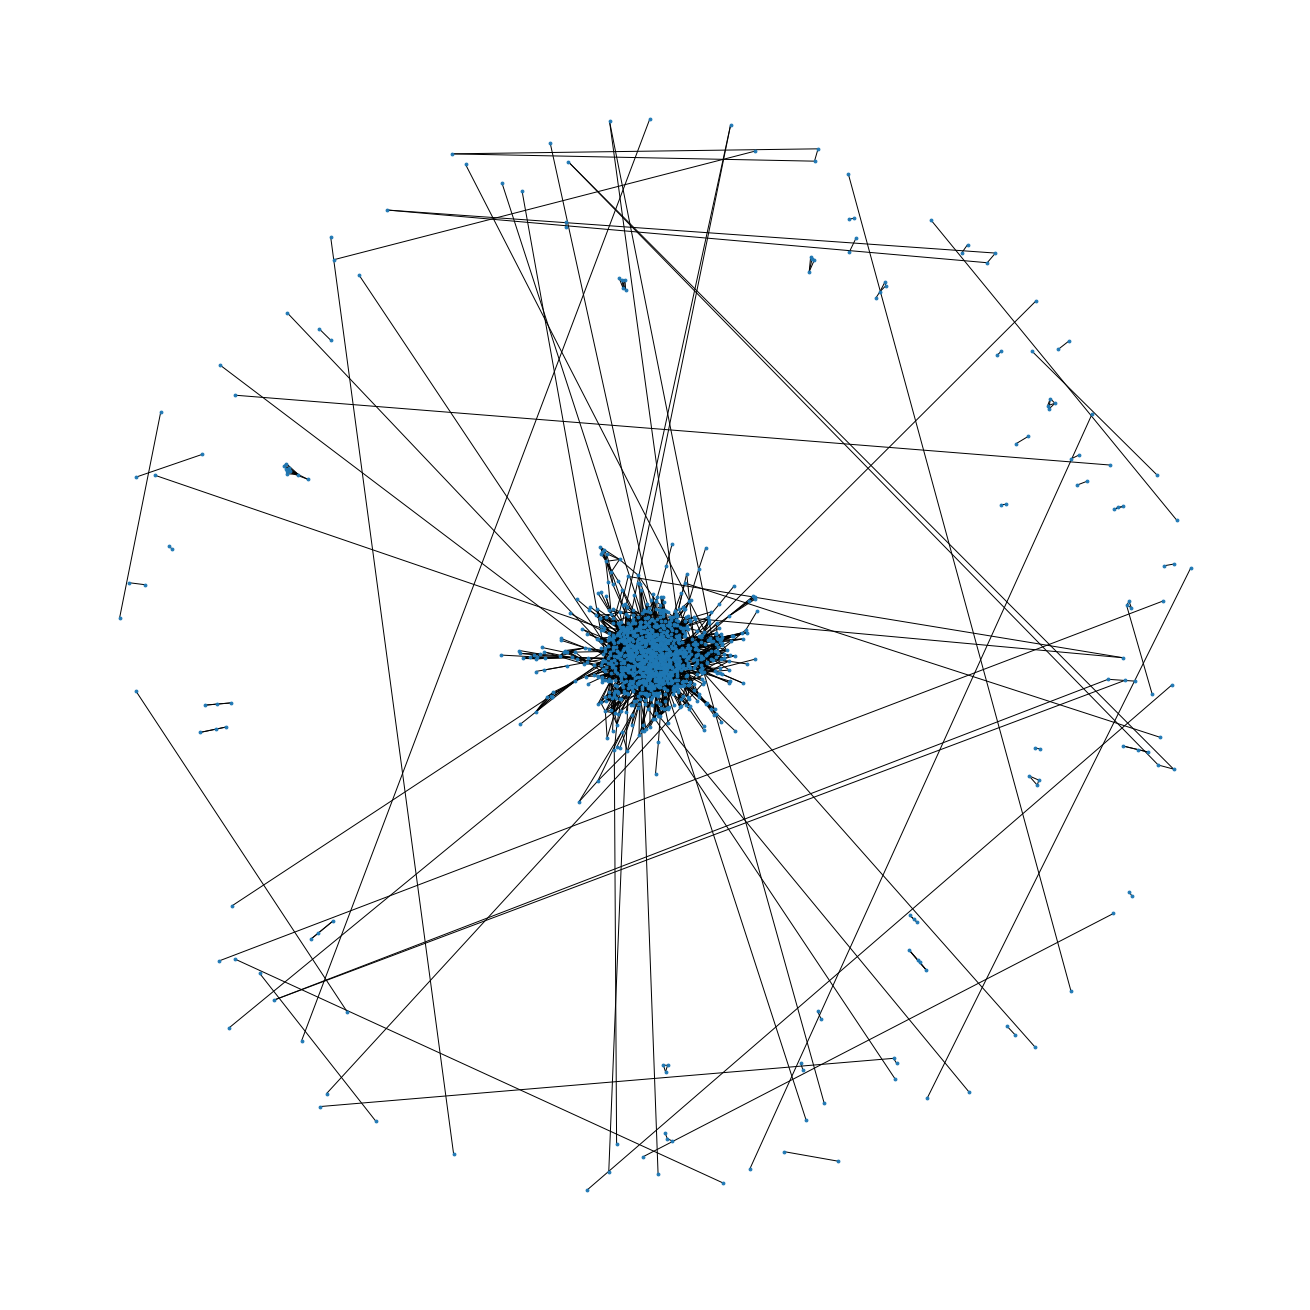

In [82]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(emotionRelevanceWeight, 'node0', 'node1', edge_attr = 'weight')
plt.figure(3,figsize=(18,18)) 
nx.draw(G, node_size=8,font_size=8) 
plt.show()


In [ ]:
df = emotionRelevanceWeight
df

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [ ]:
import matplotlib.pyplot as plt
df = emotionRelevanceWeight
plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_edgelist(df, source='node0', target='node1') 

# g.nodes()
# [g.degree(node) for node in g.nodes() if node in df.node1]
g.degree('happy')